# Professional Classifier Transformer
## In this notebook I'm going to Download, Preprocess, Model and train a Professional VIT (ViT-H-14).

## importing Libraries
1. `torch, torch.nn, torch.optim, torch.utils.data` and `torchvision` to create model and preprocessors
2. `numpy` to change image types if needed
3. `matplotlib` to plot and show the Data and loss curves
4. `os` to count cpu
5. `requests` to download dataset
6. `zipfile` to unzip dataset
7. `pathlib` to control and work with the directories

In [32]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image

## Download Dataset
This dataset contains 3 classes of 600 food images, `Pizza`, `Steak` and `Sushi`.

* 450 train images
* 150 test images

In [33]:
data_path  = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists...Stop Downloading")
else:
  print("Downloading the data...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the dataset
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    data = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    f.write(data.content)

  # Unzipping the dataset
  print("Unzipping the files...")
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    zip_file.extractall(image_path)

print("Process finished successfully...")

data/pizza_steak_sushi already exists...Stop Downloading
Process finished successfully...


In [34]:
def walk_through_dir(dir_path):
  """Walk through directory path and returning its contents."""
  for dirpath, dirnames, dirfiles in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(dirfiles)} files in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 files in data/pizza_steak_sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/test
There are 0 directories and 46 files in data/pizza_steak_sushi/test/sushi
There are 0 directories and 46 files in data/pizza_steak_sushi/test/pizza
There are 0 directories and 58 files in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 files in data/pizza_steak_sushi/train
There are 0 directories and 150 files in data/pizza_steak_sushi/train/sushi
There are 0 directories and 154 files in data/pizza_steak_sushi/train/pizza
There are 0 directories and 146 files in data/pizza_steak_sushi/train/steak


In [35]:
import random
def plot_images(image_paths, seed=None):
    # Set seed
    if seed:
        random.seed(seed)

    # Create figure
    plt.figure(figsize=(16, 9))

    # Get random images
    random_samples = random.sample(list(image_paths.glob("*/*/*.jpg")), k=5)

    for i, image in enumerate(random_samples):  # Added enumerate to get index
        img = Image.open(image)
        img_class = image.parent.stem  # Removed parentheses

        # Plot the image
        plt.subplot(1, 5, i+1)  # Using loop index instead of image
        plt.imshow(img)
        plt.title(img_class)  # Added title to show the class
        plt.axis(False)

    plt.show()  # Show the plot

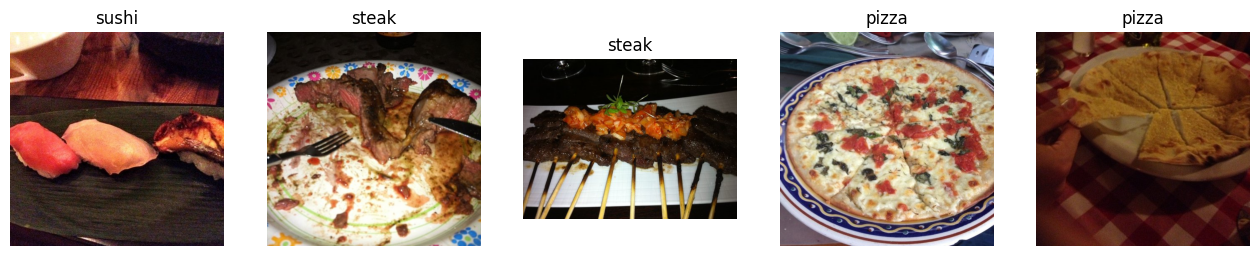

In [36]:
plot_images(image_path)

## Creating Torch Dataset

In [37]:
# Import torchvision models and transforms for vision tasks
import torchvision.models as models
from torchvision.transforms import InterpolationMode

# Load default weights for ViT_H_14 (Vision Transformer - Huge, patch size 14)
weights = models.ViT_H_14_Weights.DEFAULT

# Define the image size expected by the model (ViT-H-14 typically uses 518x518)
image_size = 518

# Training data transformations (augmentations to improve generalization)
manual_transforms_training = transforms.Compose([
    # 1. Randomly resize and crop the image to introduce scale invariance.
    #    - Scales between 80% and 100% of original size (0.8, 1.0).
    #    - Uses bicubic interpolation for smoother resizing.
    transforms.RandomResizedCrop(size=image_size, scale=(0.8, 1.0), interpolation=InterpolationMode.BICUBIC),

    # 2. Randomly flip the image horizontally (50% probability).
    #    - Simulates different orientations of the same object.
    transforms.RandomHorizontalFlip(p=0.5),

    # 3. Apply TrivialAugmentWide (automated augmentation policy).
    #    - Uses 31 magnitude bins for intensity variations.
    transforms.TrivialAugmentWide(num_magnitude_bins=31),

    # 4. Convert PIL Image or numpy array to PyTorch tensor (range [0, 1]).
    #    - Required before normalization.
    transforms.ToTensor(),

    # 5. Normalize the tensor with ImageNet stats (mean and std).
    #    - Pre-trained models expect this normalization.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation data transformations (deterministic, no augmentations)
manual_transforms_validation = transforms.Compose([
    # 1. Resize the smaller edge to `image_size` while preserving aspect ratio.
    #    - Uses bicubic interpolation for better quality.
    transforms.Resize(size=image_size, interpolation=InterpolationMode.BICUBIC),

    # 2. Crop the center region to the exact `image_size x image_size`.
    #    - Ensures consistent input dimensions.
    transforms.CenterCrop(size=image_size),

    # 3. Convert to tensor (same as training).
    transforms.ToTensor(),

    # 4. Normalize identically to training for consistency.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Optional: Use the model's built-in transforms (commented out for manual control)
# auto_transforms = weights.transforms()
# print("\nImage Transforms required by the model:")
# print(transforms)

In [38]:
train_dir = image_path / "train"
test_dir  = image_path / "test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=manual_transforms_training)
test_dataset  = datasets.ImageFolder(root=test_dir , transform=manual_transforms_validation)

print(f"We have {len(train_dataset)} images to train our model, and {len(test_dataset)} images to test our model.")

We have 450 images to train our model, and 150 images to test our model.


In [39]:
img_sample = train_dataset[0][0]
lbl_sample = train_dataset[0][1]

"First image shape:", img_sample.shape, "First image label:", lbl_sample

('First image shape:', torch.Size([3, 518, 518]), 'First image label:', 0)

## Creating DataLoaders

In [40]:
num_workers = os.cpu_count()

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True , num_workers=num_workers, batch_size=batch_size)
test_dataloader  = DataLoader(dataset=test_dataset , shuffle=False, num_workers=num_workers, batch_size=batch_size)

print(f"We have {len(train_dataloader)} batches of {batch_size} in train dataloader.")
print(f"We have {len(test_dataloader)}  batches of {batch_size} in test  dataloader.")

We have 15 batches of 32 in train dataloader.
We have 5  batches of 32 in test  dataloader.


## Vision Transformer (ViT) Model Setup

This code sets up a Vision Transformer (ViT-H-14) model with pretrained weights and prepares it for transfer learning:

1. **Model Initialization**:
   - Uses `torchvision.models` to load the ViT-H-14 architecture
   - Loads default pretrained weights (`ViT_H_14_Weights.DEFAULT`)
   - Moves the model to the specified device (GPU/CPU)

2. **Freezing Parameters**:
   - All model parameters are frozen by setting `requires_grad=False`
   - This preserves the pretrained feature extraction capabilities

3. **Classifier Head Modification**:
   - Gets the input features dimension from the original head
   - Replaces the final classification head with a new linear layer:
     - Maintains the same input dimension
     - Changes output dimension to match our 3-class problem
     - Ensures the new layer is on the correct device

This setup is typical for transfer learning scenarios where we want to leverage pretrained vision transformer features while adapting the model to a new task.

In [9]:
!pip install torchinfo

In [10]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# Initialize a Vision Transformer (ViT-H-14) model with pre-trained weights
# and move it to the specified device (e.g., 'cuda' or 'cpu')
model = models.vit_h_14(weights=weights).to(device)
model  # This will print the model architecture

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [00:25<00:00, 97.8MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1280, out_features=5120, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=5120, out_features=1280, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
       

In [41]:
for param in model.parameters():
    param.requires_grad = False

In [42]:
# Get the number of input features to the classifier head
# This is needed to modify the head for our specific task
in_features = model.heads.head.in_features
print(f"\nInput features to the classifier head: {in_features}")

# Define the number of classes for our specific task (e.g., 3 classes)
num_classes = 3

# Replace the pre-trained classifier head with a new linear layer
# that matches our number of classes. The new layer is moved to the same device.
model.heads.head = nn.Linear(
    in_features=in_features,  # Input dimension stays the same
    out_features=num_classes,  # Output dimension matches our task
    device=device  # Ensure the new layer is on the correct device
)


Input features to the classifier head: 1280


In [16]:
class AdamWarmUp:
  def __init__(self, model_size, warmup_size, optimizer):
    # Initialize learning rate scheduler parameters
    self.model_size   = model_size
    self.warmup_size  = warmup_size
    self.optimizer    = optimizer
    self.current_step = 0
    self.lr          = 0

  def get_lr(self):
    # Calculate learning rate with warmup
    return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_size ** (-1.5))

  def step(self):
    # Update learning rate and optimizer step
    self.current_step += 1
    lr = self.get_lr()
    for param_group in self.optimizer.param_groups:
      param_group['lr'] = lr
    self.lr = lr
    self.optimizer.step()

In [18]:
# The hidden dimension size for vit_h_14 is 1280
model_size = 1280
warmup_steps = 4000 # You can keep this or tune it

# Set Criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer
# IMPORTANT: You are only training the head, so pass only its parameters to the optimizer
optimizer = torch.optim.Adam(params=model.heads.head.parameters(), lr=0)
transformer_optimizer = AdamWarmUp(model_size=model_size, warmup_size=warmup_steps, optimizer=optimizer)

In [23]:
print("\nPerforming a test forward pass...")
X, y = next(iter(train_dataloader))
X = X.to(device)
y = y.to(device)

model.train() # Set model to training mode
logits = model(X)
loss = criterion(logits, y)
print(loss)


Performing a test forward pass...


## Train Model

In [25]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train(model: torch.nn.Module, criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          epochs=5,
          device="cpu",
          ):

  model_results = {
        'train_loss' : [],
        'train_acc'  : [],
        'test_loss'  : [],
        'test_acc'   : [],
        "train_time": 0
  }

  start_train_time = timer()

  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch {epoch+1}\n--------------------")

    # Set the model on train mode.
    model.train()

    train_loss, train_acc = 0, 0
    test_loss , test_acc  = 0, 0

    for batch, (X, y) in enumerate(train_data):

      # 1. Send data into device.
      X, y = X.to(device), y.to(device)

      # 2. Pass data through the model.
      y_pred = model(X)

      # 3. Calculate the model error.
      loss = criterion(y_pred, y)
      train_loss += loss.item()

      # 4. optimizer zero grad.
      optimizer.optimizer.zero_grad()

      # 5. loss backward.
      loss.backward()

      # 6. optimizer step.
      optimizer.step()

      # 7. Calculate the output.
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    train_loss /= len(train_data)
    train_acc  /= len(train_data)

    # Test phase
    model.eval()
    with torch.inference_mode():
      for batch, (X, y) in enumerate(test_data):
        # 1. Send data into device.
        X, y = X.to(device), y.to(device)

        # 2. Pass data through the model.
        test_pred = model(X)

        # 3. Calculate the model error.
        loss = criterion(test_pred, y)
        test_loss += loss.item()

        # 4. Calculate the output.
        test_pred_classes = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
        test_acc += (test_pred_classes == y).sum().item()/len(test_pred_classes)

      test_loss /= len(test_data)
      test_acc  /= len(test_data)

    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    print(f"Test loss : {train_loss:.4f} | Test accuracy : {test_acc:.4f}")

    model_results["train_loss"].append(train_loss)
    model_results["train_acc"].append(train_acc)
    model_results["test_loss"].append(test_loss)
    model_results["test_acc"].append(test_acc)

  end_train_time = timer()
  total_train_time = end_train_time - start_train_time
  print(f"Total train time: {total_train_time:.4f} seconds" )
  return model_results

In [26]:
device

'cuda'

In [28]:
model_results = train(model=model, criterion=criterion,
      optimizer=transformer_optimizer,
      train_data=train_dataloader,
      test_data=test_dataloader,
      epochs=3,
      device=device)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1
--------------------
Train loss: 1.6985 | Train accuracy: 0.0146
Test loss : 1.6985 | Test accuracy : 0.0250

Epoch 2
--------------------
Train loss: 1.6919 | Train accuracy: 0.0146
Test loss : 1.6919 | Test accuracy : 0.0250

Epoch 3
--------------------
Train loss: 1.6359 | Train accuracy: 0.0187
Test loss : 1.6359 | Test accuracy : 0.0312
Total train time: 1467.5204 seconds


## Plot The Loss And Accuracy Curves

In [31]:
def plot_loss_and_acc(model_results: dict):

  train_loss = model_results["train_loss"]
  train_acc = model_results["train_acc"]
  test_loss = model_results["test_loss"]
  test_acc = model_results["test_acc"]

  epochs = range(len(train_loss))

  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="Train loss")
  plt.plot(epochs, test_loss , label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="Train accuracy")
  plt.plot(epochs, test_acc, label="Test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

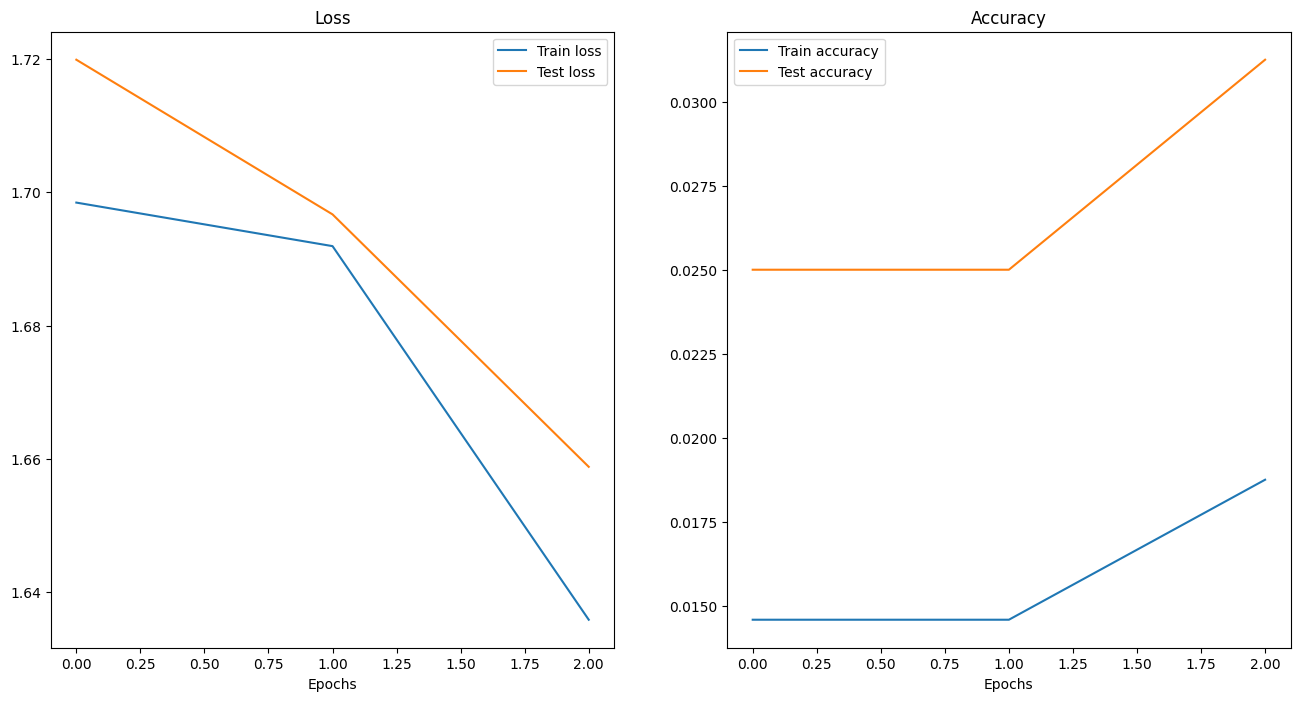

In [30]:
plot_loss_and_acc(model_results)

In [ ]:
# The reason for the network's low accuracy is
# the small volume of training data compared to the size of the network and the small number of training epochs.